# Principal Component Analysis Notebook

In [2]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import style
style.use("default")
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn import preprocessing
from sklearn.decomposition import PCA

from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

pd.options.mode.chained_assignment = None

## Data Preprocessing

In [3]:
data = load_breast_cancer()

X, y = data["data"] , data["target"]

# Create dataframe
df = pd.DataFrame(X, index = [i for i in range(len(X))], 
                  columns = ["feature_" + str(i) for i in range(X.shape[1])])
# Add y to dataframe
df["target"] = y

df.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [4]:
# Missing values
df.isnull().sum()

# Data summary
df.describe()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,target
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


In [5]:
def one_hot_encoder(df):
    data = df.copy()
    
    # Train, test & split
    data_train, data_test = train_test_split(data, test_size = 0.2, random_state = 100)
    
    # Normalization
    norm_col = df.dtypes.index[df.dtypes == "float"]
    scaler = preprocessing.StandardScaler().fit(data_train[norm_col])
    train_X = scaler.transform(data_train[norm_col])
    test_X = scaler.transform(data_test[norm_col])
    
    # Replace old values with scaled values
    data_train[norm_col] = train_X
    data_test[norm_col] = test_X
    
    
    return data_train, data_test
    
df_train, df_test = one_hot_encoder(df)    

## Principal Component Analysis

[0.43191512 0.61843533 0.7180089  0.78583409 0.8419754  0.88246161
 0.9062038  0.92394682 0.93856262 0.95096719 0.96103325 0.96995457
 0.97722656 0.98280166 0.98627566 0.9891341  0.99135001 0.99324757
 0.99472741 0.99575661 0.99676796 0.99768472 0.99838026 0.99902693
 0.99939679 0.9996782  0.99991668 0.99996932 0.99999594 1.        ]


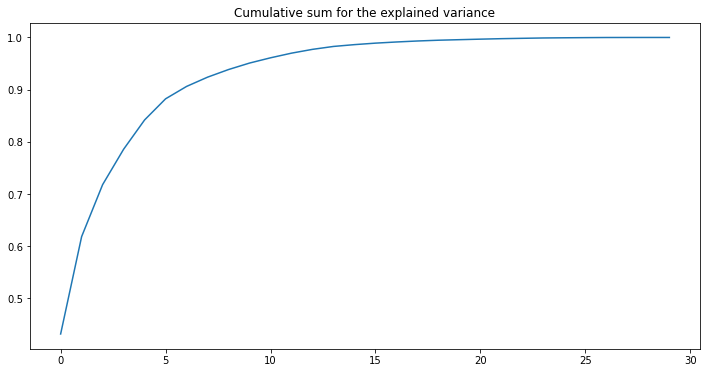

In [6]:
pca = PCA()
pca.fit(df_train.iloc[:,0:-1])

# Graphique de la variance 
plt.figure(figsize = (12,6))
plt.plot(range(30), np.cumsum(pca.explained_variance_ratio_)) # n=10 seems to be the most optimal
plt.title("Cumulative sum for the explained variance")

print(np.cumsum(pca.explained_variance_ratio_))

In [7]:
# PCA function
def PCA_function(data, n):
    pca = PCA(n_components = n)

    # X_train values
    X_train_pca = pca.fit_transform(data.iloc[:,0:-1])
    # X_test values
    X_test_pca = pca.fit_transform(data.iloc[:,0:-1])

    # Train dataframe
    df_pca = pd.DataFrame(X_train_pca, columns = ["pca" + str(i+1) for i in range(pca.components_.shape[0])])
    df_pca["target"] = data.iloc[:,-1].values
    
    df_pca.reset_index(drop = True, inplace = True)
    
    return df_pca

<AxesSubplot:xlabel='pca1', ylabel='pca2'>

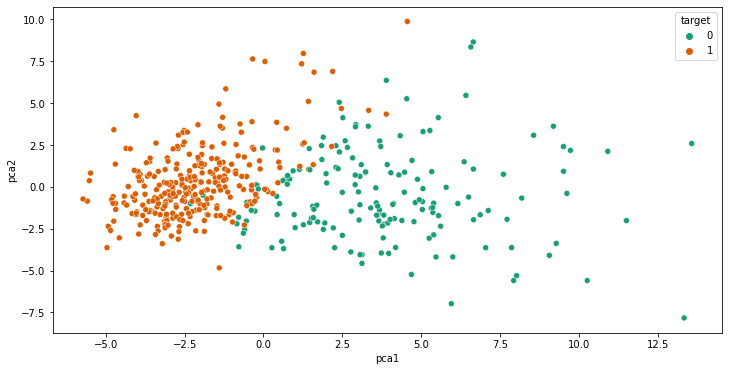

In [8]:
# Graphique PCA when n=2
df_graph = PCA_function(df_train, 2)

plt.figure(figsize = (12,6))
sns.scatterplot(data = df_graph, x = "pca1", y = "pca2", hue = "target", palette = "Dark2")

## Model Training

In [9]:
# Training and testing PCA datasets
pca_train = PCA_function(df_train, 10) 
pca_test = PCA_function(df_test, 10)

models = {
    "SVM": SVC(kernel='rbf', gamma="auto"),
    "Linear SVM": LinearSVC(max_iter=100, tol=20, random_state=42), 
    "Logistic Regression": LogisticRegression(random_state=42),
    "Decision Tree": DecisionTreeClassifier()    
}

# Model fit
for name, model in models.items():
    model.fit(pca_train.iloc[:,0:-1].values, pca_train.iloc[:,-1])
    print(name + " trained.")


SVM trained.
Linear SVM trained.
Logistic Regression trained.
Decision Tree trained.


In [11]:
# Model prediction
for name, model in models.items():
    print(name + " Accuracy:", round(model.score(pca_test.iloc[:,0:-1].values, pca_test.iloc[:,-1]), 4))

SVM Accuracy: 0.9298
Linear SVM Accuracy: 0.9298
Logistic Regression Accuracy: 0.9386
Decision Tree Accuracy: 0.9211


In [18]:
# Voting Classifier
named_models = [
    ("SVM", SVC(kernel='rbf', gamma="auto")),
    ("Linear SVM", LinearSVC(max_iter=100, tol=20, random_state=42)), 
    ("Logistic Regression", LogisticRegression(random_state=42)),
    ("Decision Tree", DecisionTreeClassifier())    
]

# Classifier
voting_clf = VotingClassifier(named_models)

# Fit data
voting_clf.fit(pca_train.iloc[:,0:-1].values, pca_train.iloc[:,-1])

# Prediction
print("Voting Classifier Accuracy", round(voting_clf.score(pca_test.iloc[:,0:-1].values, pca_test.iloc[:,-1]), 4))

Voting Classifier Accuracy 0.9386


The voting classifier does not yield better results than the logistic regression model.